In [ ]:
############################################################
"""

DJP 20200112


"""
############################################################

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import skimage
import skimage.io
from skimage import exposure
from skimage.measure import find_contours
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
from scipy import ndimage
from matplotlib import patches,  lines
from matplotlib.patches import Polygon, ConnectionPatch
import shapely
from shapely.geometry import LineString, Point 
from shapely.geometry import Polygon as sPolygon



# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

dataset_dir = "/tf/Mask_RCNN/data/HCMV_v3_AC_NUC_TB_256x256"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class HCMVConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "HCMV"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + AC & NUC & TB

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 200
    
config = HCMVConfig()
config.display()

VAL_IMAGE_IDS = ['117_20181023_repB_96hpi_821_8_RGB', 
                 '117_20181023_repB_96hpi_826_3_RGB',
                 '117_20181023_repB_96hpi_1581_7_RGB',
                 '117_20181023_repB_96hpi_275_4_RGB',
                 '117_20181023_repB_96hpi_452_1_RGB',
                 '117_20181023_repB_96hpi_575_6_RGB',
                 '117_20181023_repB_96hpi_640_9_RGB',
                 '117_20181023_repB_96hpi_865_8_RGB',
                 '117_20181023_repB_96hpi_90_8_RGB',
                 '117_20181023_repB_96hpi_943_4_RGB',
                 '117_20181023_repB_96hpi_1972_8_RGB',
                 '117_20181023_repB_96hpi_1329_2_RGB',
                 '117_20181023_repB_96hpi_1737_2_RGB',
                 '117_20181023_repB_96hpi_1856_3_RGB',
                 '117_20181023_repB_96hpi_1728_5_RGB',
                 '117_20181023_repB_96hpi_1729_9_RGB',
                 '117_20181023_repB_96hpi_1738_7_RGB',
                 '117_20181023_repB_96hpi_1744_3_RGB',
                 '117_20181023_repB_96hpi_1793_6_RGB',
                 '117_20181023_repB_96hpi_1800_6_RGB',
                 '117_20181023_repB_96hpi_1803_9_RGB',
                 '117_20181023_repB_96hpi_1984_2_RGB',
                 '117_20181023_repB_96hpi_2054_9_RGB',
                 '117_20181023_repB_96hpi_2174_1_RGB',
                 '117_20181023_repB_96hpi_2174_2_RGB',
                 '117_20181023_repB_96hpi_2223_5_RGB',
                 '117_20181023_repB_96hpi_885_7_RGB',
                 '117_20181023_repB_96hpi_2292_6_RGB',
                 '117_20181023_repB_96hpi_2299_7_RGB',
                 '117_20181023_repB_96hpi_2300_8_RGB',
                 '117_20181023_repB_96hpi_2305_4_RGB',
                 '117_20181023_repB_96hpi_233_12_RGB',
                 '117_20181023_repC_96hpi_5519_1_RGB',
                 '117_20181023_repC_96hpi_5527_3_RGB',
                 '117_20181023_repC_96hpi_5531_4_RGB',
                 '117_20181023_repC_96hpi_5577_8_RGB',
                 '117_20181023_repC_96hpi_5589_2_RGB',
                 '117_20181023_repC_96hpi_5596_1_RGB',
                 '117_20181023_repC_96hpi_5614_1_RGB',
                 '117_20181023_repC_96hpi_5651_2_RGB',
                 '117_20181023_repC_96hpi_5713_2_RGB',
                 '117_20181023_repC_96hpi_5767_6_RGB',
                 '117_20181023_repC_96hpi_5807_5_RGB',
                 '117_20181023_repC_96hpi_5813_5_RGB',
                 '117_20181023_repC_96hpi_5831_1_RGB',
                 '117_20181023_repC_96hpi_5849_5_RGB',
                 '117_20181023_repC_96hpi_5906_5_RGB',
                 '117_20181023_repC_96hpi_6063_9_RGB',
                 '117_20181023_repC_96hpi_6099_7_RGB']



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class HCMVDataset(utils.Dataset):

    def load_HCMV(self, dataset_dir, subset):
        """Load a subset of the HCMV dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset HCMV, and the class HCMV
        self.add_class("HCMV", 1, "AC")
        self.add_class("HCMV", 2, "NUC")
        self.add_class("HCMV", 3, "TB")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]
        subset_dir = "stage1_train" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir, subset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = next(os.walk(dataset_dir))[1]
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        # Add images
        for image_id in image_ids:
            self.add_image(
                "HCMV",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "images/{}.jpg".format(image_id)))

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

            
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")

        # Read mask files from .jpg image
        mask = []
        class_ids = []
        for f in next(os.walk(mask_dir))[2]:
            #assign class IDs by reading filename suffix
            if f.endswith("_AC.png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
                maskclassID = 1
                class_ids.append(maskclassID)
            elif f.endswith("_NUC.png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
                maskclassID = 2
                class_ids.append(maskclassID)
            elif f.endswith("_TB.png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
                maskclassID = 3
                class_ids.append(maskclassID)
        mask = np.stack(mask, axis=-1)
        class_ids = np.stack(class_ids, axis=-1)
        # Return mask, and array of class IDs of each instance. 
        #Since we have
        # one class ID, we return an array of ones
        return mask, class_ids

In [5]:
# Training dataset.
dataset_train = HCMVDataset()
dataset_train.load_HCMV(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = HCMVDataset()
dataset_val.load_HCMV(dataset_dir, "val")
dataset_val.prepare()

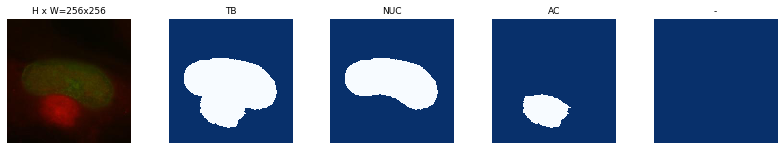

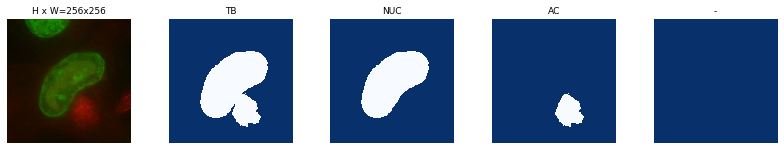

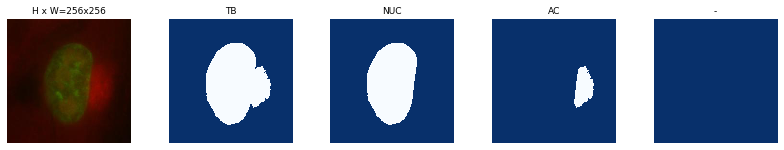

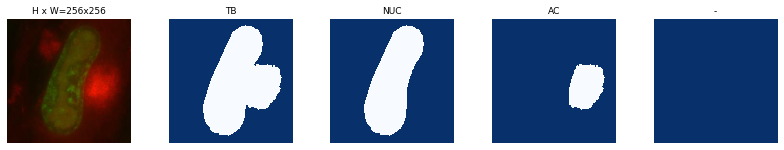

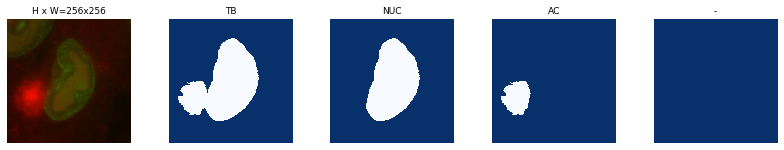

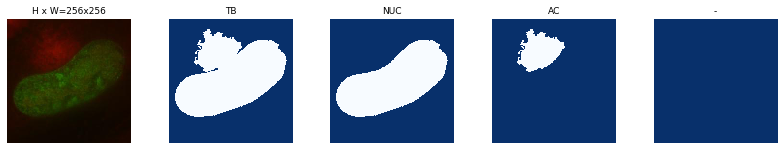

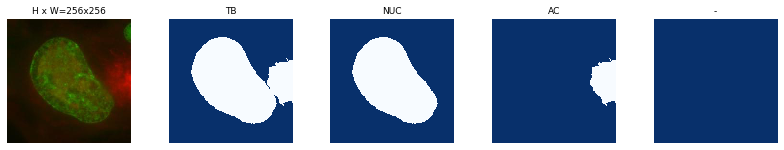

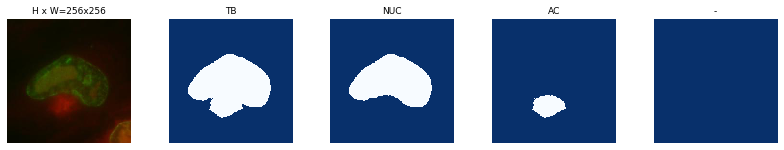

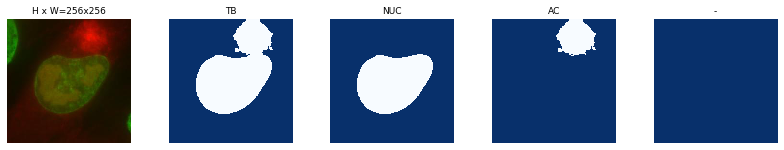

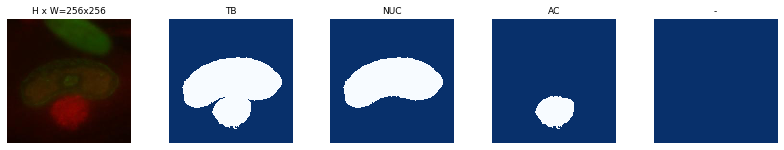

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = modellib.load_image_gt(dataset_train, config, image_id)#, use_mini_mask=False)
    image = image[0]
    mask, class_ids = dataset_train.load_mask(image_id)
    #print(image[0])
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    #model.load_weights(model.find_last(), by_name=True)
    # Get path to saved weights
    # Either set a specific path or find last trained weights
    #model_path = os.path.join("/tf/Mask_RCNN/logs/hcmv20200112T2342/mask_rcnn_hcmv_0030.h5")
    model_path = model.find_last()

    # Load trained weights
    model.load_weights(model_path, by_name=True)
    
    
###########################################################


Re-starting from epoch 80


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=80, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [9]:
class InferenceConfig(HCMVConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False
    MINI_MASK_SHAPE = (400, 400)
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024
    RPN_NMS_THRESHOLD = 0.9
    RPN_TRAIN_ANCHORS_PER_IMAGE = 2048

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join("/tf/Mask_RCNN/logs/hcmv20200112T2342/mask_rcnn_hcmv_0009.h5")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /tf/Mask_RCNN/logs/hcmv20200116T0607/mask_rcnn_hcmv_0080.h5
Re-starting from epoch 80


In [10]:
def get_mask_moments_centroid_only(mask):
    # calculate moments of binary image
    try:
        mask_M = cv2.moments(mask.astype(np.uint8))
        mask_cX = int(mask_M["m10"] / mask_M["m00"])
        mask_cY = int(mask_M["m01"] / mask_M["m00"])
    except:
        mask_cX = np.nan
        mask_cY = np.nan
    return(mask_cX, mask_cY)

def get_all_mask_centroids(class_ids,masks):
    mask_centroids = []
    for id in range(len(class_ids)):
        mask_centroids.append(get_mask_moments_centroid_only(masks[:,:,id]))
    return(mask_centroids)

def plot_masks(img,TB_mask,TB_score,AC_mask,AC_score,NUC_mask,NUC_score):
    fig, ax = plt.subplots(1,4,figsize=(15,5))
    ax[0].imshow(img)
    ax[1].imshow(TB_mask)
    ax[1].set_title(TB_score)
    ax[2].imshow(AC_mask)
    ax[2].set_title(AC_score)
    ax[3].imshow(NUC_mask)
    ax[3].set_title(NUC_score)
    plt.show()


def get_NUC_AC_closest_to_TB(all_mask_centroids,TB_mask_index):
    AC_class_id = 1
    NUC_class_id = 2
    mask_centroid_distance = []
    #get distances between TB and all other centroids
    for id in range(len(all_mask_centroids)):
        distance = np.hypot(
            (all_mask_centroids[id][0] - all_mask_centroids[TB_mask_index][0]),
            (all_mask_centroids[id][1] - all_mask_centroids[TB_mask_index][1]))
        mask_centroid_distance.append(distance)
    #make distances of TB NaN
    mask_centroid_distance[TB_mask_index] = np.NaN

    #make distances of nuclei NaN
    for id in range(len(all_mask_centroids)):
        if r['class_ids'][id] == 3:
            mask_centroid_distance[id] = np.NaN
        if mask_centroid_distance[id] > 150:
            mask_centroid_distance[id] = np.NaN
    #print(mask_centroid_distance)
    #AC_
    AC_mask_centroid_distance = mask_centroid_distance.copy()
    NUC_mask_centroid_distance = mask_centroid_distance.copy()
    for id in range(len(AC_mask_centroid_distance)):        
        if r['class_ids'][id] == NUC_class_id:
            AC_mask_centroid_distance[id] = np.NaN
            #print(AC_mask_centroid_distance)
            AC_min_dist_to_TB_index = np.nanargmin(AC_mask_centroid_distance) 
    for id in range(len(NUC_mask_centroid_distance)):
        if r['class_ids'][id] == AC_class_id:
            NUC_mask_centroid_distance[id] = np.NaN
            try:
                NUC_min_dist_to_TB_index = np.nanargmin(NUC_mask_centroid_distance) 
            except:
                NUC_min_dist_to_TB_index = "TB"
    
    #get the index of the AC closest to NUC
    
    #get the index of the AC closest to NUC
    
    return(NUC_min_dist_to_TB_index,AC_min_dist_to_TB_index)
"""
def get_NUC_AC_within_TB(all_mask_centroids,TB_mask_index):
    AC_class_id = 1
    NUC_class_id = 2
    
    x_min = r['rois'][TB_mask_index][1]
    x_max = r['rois'][TB_mask_index][3]
    
    y_min = r['rois'][TB_mask_index][2]
    y_max = r['rois'][TB_mask_index][0]
    
    for mask_id in range(len(all_mask_centroids)):
        if x_min <= all_mask_centroids[mask_id][0] <=x_max and y_min <= all_mask_centroids[mask_id][1] <=y_max:
            if r['class_ids'][mask_id] == NUC_class_id:
                NUC_in_roi_index = mask_id
            if r['class_ids'][mask_id] == AC_class_id:
                AC_in_roi_index = mask_id
    return(NUC_in_roi_index, AC_in_roi_index)
"""

"\ndef get_NUC_AC_within_TB(all_mask_centroids,TB_mask_index):\n    AC_class_id = 1\n    NUC_class_id = 2\n    \n    x_min = r['rois'][TB_mask_index][1]\n    x_max = r['rois'][TB_mask_index][3]\n    \n    y_min = r['rois'][TB_mask_index][2]\n    y_max = r['rois'][TB_mask_index][0]\n    \n    for mask_id in range(len(all_mask_centroids)):\n        if x_min <= all_mask_centroids[mask_id][0] <=x_max and y_min <= all_mask_centroids[mask_id][1] <=y_max:\n            if r['class_ids'][mask_id] == NUC_class_id:\n                NUC_in_roi_index = mask_id\n            if r['class_ids'][mask_id] == AC_class_id:\n                AC_in_roi_index = mask_id\n    return(NUC_in_roi_index, AC_in_roi_index)\n"

In [11]:
# TODO: if multiple AC within ROI, then pick the one with the largest size or score
def get_NUC_AC_masks(masks,rois,scores):
    AC_class_id = 1
    NUC_class_id = 2

    TB_mask = masks[:,:,x]
    TB_roi = rois[x]
    TB_score = scores[x]
    y1, x1, y2, x2 = TB_roi

    for mask_id in range(len(mask_centroids)):
        #print(mask_centroids[mask_id])
        #print(scores[mask_id])
        if x1 <= mask_centroids[mask_id][0] <= x2 and y1 <= mask_centroids[mask_id][1] <= y2:
            if class_ids[mask_id] == NUC_class_id:
                NUC_mask = masks[:,:,mask_id]
                NUC_score = scores[mask_id]
                NUC_coords = mask_centroids[mask_id]
                #print("NUC_ID=",mask_id, "score=", NUC_score)   
            elif class_ids[mask_id] == AC_class_id:
                #print("AC_ID=",mask_id)
                AC_mask = masks[:,:,mask_id]
                AC_score = scores[mask_id]
                AC_coords = mask_centroids[mask_id]            
    #plot_masks(img,TB_mask,TB_score,AC_mask,AC_score,NUC_mask,NUC_score)
    return(TB_mask, AC_mask, NUC_mask, TB_roi, AC_coords, NUC_coords, TB_score, AC_score, NUC_score)

def get_8bitRG_from_folder(image_no):
    image_no_string = "_s{}_".format(image_no)
    img_C1_path = [k for k in images_C1 if image_no_string in k]
    img_C4_path = [k for k in images_C4 if image_no_string in k]
    img_C1_16bit = skimage.io.imread(os.path.join(image_dir,img_C1_path[0]), as_gray=True, plugin='tifffile')
    img_C4_16bit = skimage.io.imread(os.path.join(image_dir,img_C4_path[0]), as_gray=True, plugin='tifffile')
    img_C1_16bit_adapteq = exposure.equalize_adapthist(img_C1_16bit, clip_limit=0.01)
    img_C4_16bit_adapteq = exposure.equalize_adapthist(img_C4_16bit, clip_limit=0.0025)
    img_C1_8bit = (img_C1_16bit_adapteq*256).astype('uint8')
    img_C4_8bit = (img_C4_16bit_adapteq*256).astype('uint8')
    img_blank_8bit = img_C1_8bit * 0 # this makes it black
    merged_channels = cv2.merge((img_C1_8bit,img_C4_8bit,img_blank_8bit))
    img = Image.fromarray(merged_channels)
    merge_channels = None
    img = img.resize((img_size,img_size))
    img = np.array(img)
    return(img)

def get_RGB_from_folder(image_folder,file):
    img = Image.open(os.path.join(image_folder, file))
    img = img.resize((img_size,img_size))
    img = np.array(img)
    return(img)

def prepare_image_channels(image_dir):
    images = os.listdir(image_dir)
    images_C1 = [k for k in images if '_w1_' in k]
    images_C2 = [k for k in images if '_w2_' in k]
    images_C3 = [k for k in images if '_w3_' in k]
    images_C4 = [k for k in images if '_w4_' in k]
    return(images_C1,images_C2,images_C3,images_C4)

def set_vars_none():
    AC_mask = None
    NUC_mask = None
    AC_score = None
    NUC_score = None
    AC_coords = None
    NUC_coords = None
    TB_roi = None

def get_results(img, visualize_instances=False):
    results = model.detect([img], verbose=0)
    r=results[0]
    masks = r['masks']
    class_ids = r['class_ids']
    scores = r["scores"]
    rois = r['rois']
    if visualize_instances == True:
        visualize.display_instances(img, rois, masks, class_ids, dataset_val.class_names, scores, ax=get_ax())
        plt.show()
    return(masks, scores, rois, class_ids)

def get_orientation(ACx,ACy,NUCx,NUCy):
    AC_to_NUC_orientation_radians =  np.arctan2((ACy - NUCy),(ACx - NUCx))
    if AC_to_NUC_orientation_radians <0:
        AC_to_NUC_orientation_radians = 2*np.pi+AC_to_NUC_orientation_radians
    AC_to_NUC_orientation_degrees = np.degrees(AC_to_NUC_orientation_radians)
    return(AC_to_NUC_orientation_degrees, AC_to_NUC_orientation_radians)

def rotate_align_AC(img,int_x,int_y,AC_to_NUC_orientation_degrees):
    SHIFT_x = int(img_size/2 - int_x)
    SHIFT_y = int(img_size/2 - int_y)
    img = Image.fromarray(img)
    image_rot = img.rotate(AC_to_NUC_orientation_degrees,
                                        center=(int(int_x), int(int_y)),
                                        translate=(SHIFT_x,SHIFT_y))
    return(image_rot)

#colors = visualize.random_colors(3)

def display_mask_HCMV(img,TB_mask,AC_mask,NUC_mask,roi,AC_coords,NUC_coords,TB_score,AC_score,NUC_score):
    
    figsize=(15, 5)
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=figsize)
    
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    fig.set_facecolor("black")
    
    fig.subplots_adjust(wspace=0.0025)
    masked_image = img.astype(np.uint32).copy()
    y1, x1, y2, x2 = roi
    
    line_color = colors[1]

    p1a = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                        alpha=0.7, linestyle="dashed",
                        edgecolor=line_color, facecolor='none')
    p1b = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                        alpha=0.7, linestyle="dashed",
                        edgecolor=line_color, facecolor='none')
    ax1.add_patch(p1a)
    ax2.add_patch(p1b)
    
    #TB label
    TB_caption = "HCMV:{:.4f}".format(TB_score)
    ax1.text(x1, (y1-25), TB_caption, color=line_color, size=10, bbox=dict(boxstyle='square,pad=0.2', fc='none', ec=line_color))
    
    # NUC_Mask
    masked_image = visualize.apply_mask(masked_image, NUC_mask, colors[2],alpha=0.1)
    padded_mask = np.zeros((NUC_mask.shape[0] + 2, NUC_mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = NUC_mask
    contours = find_contours(padded_mask, 0.5)
    nuc_polygon = []
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p1 = Polygon(verts, facecolor="none", edgecolor=colors[2])
        p2 = Polygon(verts, facecolor="none", edgecolor=colors[2])
        ax1.add_patch(p1)
        ax2.add_patch(p2)
        nuc_polygon.append(verts)
    ax2.plot(NUC_coords[0], NUC_coords[1], color=colors[2], marker='o', markersize=12)
    NUC_caption = "NUC:{:.4f}".format(NUC_score)
    ax2.text((NUC_coords[0]+10), (NUC_coords[1]+10), NUC_caption,color=colors[2], size=10, bbox=dict(boxstyle='square,pad=0.2', fc='none', ec=colors[2]))

        
    # AC_Mask
    masked_image = visualize.apply_mask(masked_image, AC_mask, colors[0],alpha=0.1)
    padded_mask = np.zeros((AC_mask.shape[0] + 2, AC_mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = AC_mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p1 = Polygon(verts, facecolor="none", edgecolor=colors[0])
        p2 = Polygon(verts, facecolor="none", edgecolor=colors[0])
        ax1.add_patch(p1)
        ax2.add_patch(p2)
    ax1.imshow(masked_image.astype(np.uint8))
    ax2.imshow(masked_image.astype(np.uint8))
    ax2.plot(AC_coords[0], AC_coords[1], color=colors[0], marker='o', markersize=12)
    AC_caption = "AC:{:.4f}".format(AC_score)
    ax2.text((AC_coords[0]+10), (AC_coords[1]+10), AC_caption,color=colors[0], size=10, bbox=dict(boxstyle='square,pad=0.2', fc='none', ec=colors[0]))
    
    #get intersection of NUC to AC and NUC edge
    nuc_polygon_array = np.array(nuc_polygon)
    polygon = sPolygon(np.squeeze(nuc_polygon_array.astype(int)[0]))
    line1 = LineString([AC_coords, NUC_coords])
    int_pt = line1.intersection(polygon)
    int_pt.wkt
    ax2.plot([int_pt.coords[0][0]],[int_pt.coords[0][1]],marker='o', markersize=12, color="white")
    ax2.plot([AC_coords[0],NUC_coords[0]], [AC_coords[1],NUC_coords[1]],linestyle='-', color="white")

    coordsA = "data"
    coordsB = "data"
    
    con1 = ConnectionPatch(xyA=(x1,y1), xyB=(x2,y1), coordsA=coordsA, coordsB=coordsB,
                          axesA=ax2, axesB=ax1,
                          arrowstyle="-", shrinkB=5,linewidth=2, alpha=0.7, linestyle="dashed",edgecolor=line_color)
    
    con2 = ConnectionPatch(xyA=(x1,y2), xyB=(x2,y2), coordsA=coordsA, coordsB=coordsB,
                          axesA=ax2, axesB=ax1,
                          arrowstyle="-", shrinkB=5,linewidth=2, alpha=0.7, linestyle="dashed",edgecolor=line_color)
    ax2.add_artist(con1)
    ax2.add_artist(con2)
    
    AC_to_NUC_orientation_degrees = get_orientation(AC_coords[0],AC_coords[1],NUC_coords[0],NUC_coords[1])
    print(AC_to_NUC_orientation_degrees)
    image_rot = rotate_align_AC(img,int(int_pt.coords[0][0]),int(int_pt.coords[0][1]),AC_to_NUC_orientation_degrees)
    ax3.imshow(image_rot)
    
    
    x_mid = (x1+x2)/2
    y_mid = (y1+y2)/2
    
    x_len = x2-x1 
    y_len = y2-y1
    
    max_len = max(x_len,y_len)
    
    x_min = x_mid - max_len/2 - 25
    x_max = x_mid + max_len/2 + 25
    
    y_min = y_mid - max_len/2 - 25
    y_max = y_mid + max_len/2 + 25
    
    ax2.set_xlim(x_min,x_max)
    ax2.set_ylim(y_max,y_min)

    x_min = img_size/2 - max_len/2 - 25
    x_max = img_size/2 + max_len/2 + 25
    
    y_min = img_size/2 - max_len/2 - 25
    y_max = img_size/2 + max_len/2 + 25
    
    ax3.set_xlim(x_min,x_max)
    ax3.set_ylim(y_max,y_min)

    plt.show()

In [12]:
from skimage.transform import resize
from math import sin, cos, radians, pi
def point_pos(x0, y0, d, theta):
    theta_rad = pi/2 - radians(theta)
    return x0 + d*cos(theta_rad), y0 + d*sin(theta_rad)

def load_all_channels(image_no):
    image_no_string = "_s{}_".format(image_no)
    image_rep_string = "_repG_"
    
    img_C1_rep = [k for k in images_C1 if image_rep_string in k] 
    img_C2_rep = [k for k in images_C2 if image_rep_string in k] 
    img_C3_rep = [k for k in images_C3 if image_rep_string in k] 
    img_C4_rep = [k for k in images_C4 if image_rep_string in k] 
    
    img_C1_path = [k for k in img_C1_rep if image_no_string in k]
    img_C2_path = [k for k in img_C2_rep if image_no_string in k]
    img_C3_path = [k for k in img_C3_rep if image_no_string in k]
    img_C4_path = [k for k in img_C4_rep if image_no_string in k]
    
    img_C1_16bit = skimage.io.imread(os.path.join(image_dir,img_C1_path[0]), as_gray=True, plugin='tifffile')
    img_C2_16bit = skimage.io.imread(os.path.join(image_dir,img_C2_path[0]), as_gray=True, plugin='tifffile')
    img_C3_16bit = skimage.io.imread(os.path.join(image_dir,img_C3_path[0]), as_gray=True, plugin='tifffile')
    img_C4_16bit = skimage.io.imread(os.path.join(image_dir,img_C4_path[0]), as_gray=True, plugin='tifffile')

    
    img_C1_16bit_adapteq = exposure.equalize_adapthist(img_C1_16bit, clip_limit=0.01)
    img_C4_16bit_adapteq = exposure.equalize_adapthist(img_C4_16bit, clip_limit=0.0025)
    img_C1_8bit = (img_C1_16bit_adapteq*256).astype('uint8')
    img_C4_8bit = (img_C4_16bit_adapteq*256).astype('uint8')
    img_blank_8bit = img_C1_8bit * 0 # this makes it black
    merged_channels = cv2.merge((img_C1_8bit,img_C4_8bit,img_blank_8bit))
    img_C1_16bit_adapteq = None
    img_C4_16bit_adapteq = None
    img = Image.fromarray(merged_channels)
    merge_channels = None
    img = img.resize((img_size,img_size))
    img = np.array(img)
    return(img, img_C1_16bit, img_C2_16bit, img_C3_16bit, img_C4_16bit)

colors = [(0.0, 0.0, 1.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0)]

def display_mask_HCMV_rotateall(img,TB_mask,AC_mask,NUC_mask,roi,AC_coords,NUC_coords,TB_score,AC_score,NUC_score, image_C1, image_C2, image_C3, image_C4):
    
    figsize=(15, 15)
    linescan_len = 500
    linescan_width = 250
    
    #setup figure and axes 
    plt.style.use(['dark_background'])
    fig, ax = plt.subplots(ncols=3,nrows=3,figsize=figsize)
    for i in [0,1,2]:
        for j in [0,1,2]:
            ax[i,j].axes.get_yaxis().set_visible(False)
            ax[i,j].axes.get_xaxis().set_visible(False)
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0.05)
    
    masked_image = img.astype(np.uint32).copy()
    
    #get TB mask bounding boxs / rois and draw on images
    y1, x1, y2, x2 = roi
    line_color = colors[1]
    p1a = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                        alpha=0.7, linestyle="dashed",
                        edgecolor=line_color, facecolor='none')
    p1b = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                        alpha=0.7, linestyle="dashed",
                        edgecolor=line_color, facecolor='none')
    ax[0,0].add_patch(p1a)
    ax[0,1].add_patch(p1b)
    
    #TB label
    TB_caption = "HCMV:{:.4f}".format(TB_score)
    ax[0,0].text(x1, (y1-30), TB_caption, color=line_color, size=10,clip_on=True, bbox=dict(boxstyle='square,pad=0.2', fc='none', ec=line_color))
    
    # NUC_Mask
    masked_image = visualize.apply_mask(masked_image, NUC_mask, colors[2],alpha=0.1)
    padded_mask = np.zeros((NUC_mask.shape[0] + 2, NUC_mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = NUC_mask
    contours = find_contours(padded_mask, 0.5)
    nuc_polygon = []
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p1 = Polygon(verts, facecolor="none", edgecolor=colors[2])
        p2 = Polygon(verts, facecolor="none", edgecolor=colors[2])
        ax[0,0].add_patch(p1)
        ax[0,1].add_patch(p2)
        nuc_polygon.append(verts)
    ax[0,1].plot(NUC_coords[0], NUC_coords[1], color=colors[2], marker='o', markersize=12)
    NUC_caption = "NUC:{:.4f}".format(NUC_score)
    ax[0,1].text((NUC_coords[0]+10), (NUC_coords[1]+10), NUC_caption,color=colors[2], size=10,clip_on=True, bbox=dict(boxstyle='square,pad=0.2', fc='none', ec=colors[2]))

        
    # AC_Mask
    masked_image = visualize.apply_mask(masked_image, AC_mask, colors[0],alpha=0.1)
    padded_mask = np.zeros((AC_mask.shape[0] + 2, AC_mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = AC_mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p1 = Polygon(verts, facecolor="none", edgecolor=colors[0])
        p2 = Polygon(verts, facecolor="none", edgecolor=colors[0])
        ax[0,0].add_patch(p1)
        ax[0,1].add_patch(p2)
    ax[0,0].imshow(masked_image.astype(np.uint8))
    ax[0,1].imshow(masked_image.astype(np.uint8))
    ax[0,1].plot(AC_coords[0], AC_coords[1], color=colors[0], marker='o', markersize=12)
    AC_caption = "AC:{:.4f}".format(AC_score)
    ax[0,1].text((AC_coords[0]+10), (AC_coords[1]+10), AC_caption,color=colors[0], size=10,clip_on=True, bbox=dict(boxstyle='square,pad=0.2', fc='none', ec=colors[0]))
    
    coordsA = "data"
    coordsB = "data"
    
    con1 = ConnectionPatch(xyA=(x1,y1), xyB=(x2,y1), coordsA=coordsA, coordsB=coordsB,
                          axesA=ax[0,1], axesB=ax[0,0],
                          arrowstyle="-", shrinkB=5,linewidth=2, alpha=0.7, linestyle="dashed",edgecolor=line_color)
    
    con2 = ConnectionPatch(xyA=(x1,y2), xyB=(x2,y2), coordsA=coordsA, coordsB=coordsB,
                          axesA=ax[0,1], axesB=ax[0,0],
                          arrowstyle="-", shrinkB=5,linewidth=2, alpha=0.7, linestyle="dashed",edgecolor=line_color)
    ax[0,1].add_artist(con1)
    ax[0,1].add_artist(con2)
    
    AC_to_NUC_orientation_degrees, AC_to_NUC_orientation_radians = get_orientation(AC_coords[0],AC_coords[1],NUC_coords[0],NUC_coords[1])
    
    #get intersection of NUC to AC line and NUC mask polygon
    nuc_polygon_array = np.array(nuc_polygon)
    polygon = sPolygon(np.squeeze(nuc_polygon_array.astype(int)[0]))
    #this needs to be the linescan line
    line1 = LineString([AC_coords, NUC_coords])
    int_pt = line1.intersection(polygon)
    
    intersection_x = int_pt.coords[0][0]
    intersection_y = int_pt.coords[0][1]
    
    ax[0,1].plot(intersection_x,intersection_y,marker='o', markersize=12, color="white")
    
    image_rot = rotate_align_AC(img,int(intersection_x),int(intersection_y),AC_to_NUC_orientation_degrees)
    ax[0,2].imshow(image_rot)
    
    X_AC_fr,Y_AC_fr,X_NUC_fr,Y_NUC_fr = linescan_calculations(intersection_x,intersection_y,AC_to_NUC_orientation_radians, linescan_len)
    
    line2 = LineString([NUC_coords, (X_NUC_fr,Y_NUC_fr)])
    int_pt_2 = line2.intersection(polygon)
    intersection_x_far = int_pt_2.coords[1][0]
    intersection_y_far = int_pt_2.coords[1][1]
    ax[0,1].plot(intersection_x_far,intersection_y_far,marker='o', markersize=12, color="white")
    
    nuc_len= math.hypot(intersection_x - intersection_x_far, intersection_y - intersection_y_far)
    for i in [0,1,2]:

        #draw verticle lines on the graph
        ax[2,i].axvline(x=linescan_len+25, dashes=[6,6], linewidth=2,color='lime',alpha=0.5)
        ax[2,i].axvline(x=(linescan_len-nuc_len*2-25), dashes=[6,6], linewidth=2,color='lime',alpha=0.5)
        #ax[1,i].axvspan((linescan_len-nuc_len*2), linescan_len, alpha=0.2, color='green')
    
    #our predictions are made on an image half the size of the original, so to get linescans on full resolution data, multiply by 2
    intersection_x_FULLSIZE = intersection_x*2
    intersection_y_FULLSIZE = intersection_y*2
    
    image_C1_rot = rotate_align_AC_FULLSIZE(image_C1,intersection_x_FULLSIZE,intersection_y_FULLSIZE,AC_to_NUC_orientation_degrees)
    image_C2_rot = rotate_align_AC_FULLSIZE(image_C2,intersection_x_FULLSIZE,intersection_y_FULLSIZE,AC_to_NUC_orientation_degrees)
    image_C3_rot = rotate_align_AC_FULLSIZE(image_C3,intersection_x_FULLSIZE,intersection_y_FULLSIZE,AC_to_NUC_orientation_degrees)
    image_C4_rot = rotate_align_AC_FULLSIZE(image_C4,intersection_x_FULLSIZE,intersection_y_FULLSIZE,AC_to_NUC_orientation_degrees)

    # cropped = img.crop( ( x, y, x + width , y + height ) )
    image_C1_rot_crop = image_C1_rot.crop((723,723,1323,1323))
    image_C2_rot_crop = image_C2_rot.crop((723,723,1323,1323))
    image_C3_rot_crop = image_C3_rot.crop((723,723,1323,1323))
    image_C4_rot_crop = image_C4_rot.crop((723,723,1323,1323))
    
    os.makedirs("rotated_099_repG", exist_ok=True)
    skimage.io.imsave("rotated_099_repG/121_20200201_repG_img{}_coords{}_{}_C1.tif".format(image_no,int(intersection_x_FULLSIZE),int(intersection_y_FULLSIZE)),np.asanyarray(image_C1_rot_crop))
    skimage.io.imsave("rotated_099_repG/121_20200201_repG_img{}_coords{}_{}_C2.tif".format(image_no,int(intersection_x_FULLSIZE),int(intersection_y_FULLSIZE)),np.asanyarray(image_C2_rot_crop))
    skimage.io.imsave("rotated_099_repG/121_20200201_repG_img{}_coords{}_{}_C3.tif".format(image_no,int(intersection_x_FULLSIZE),int(intersection_y_FULLSIZE)),np.asanyarray(image_C3_rot_crop))
    skimage.io.imsave("rotated_099_repG/121_20200201_repG_img{}_coords{}_{}_C4.tif".format(image_no,int(intersection_x_FULLSIZE),int(intersection_y_FULLSIZE)),np.asanyarray(image_C4_rot_crop))

    ax[1,0].imshow(image_C1_rot,cmap = 'nipy_spectral')
    ax[1,1].imshow(image_C2_rot,cmap = 'nipy_spectral')
    ax[1,2].imshow(image_C4_rot,cmap = 'nipy_spectral')
    
    #collect the linescans 
    linescan_C1,linescan_mean_C1,linescan_stdev_C1,linescan_C2,linescan_mean_C2,linescan_stdev_C2,linescan_C3,linescan_mean_C3,linescan_stdev_C3 = get_single_linescan_TB96(X_AC_fr,Y_AC_fr,X_NUC_fr,Y_NUC_fr,linescan_width,image_C1,image_C2,image_C3,image_C4)
    
    #draw linescans positions on the images
    l = data_linewidth_plot([X_AC_fr,X_NUC_fr], [Y_AC_fr,Y_NUC_fr], ax=ax[0,0], linewidth=linescan_width/2, alpha=0.25, color='white')
    l = data_linewidth_plot([X_AC_fr,X_NUC_fr], [Y_AC_fr,Y_NUC_fr], ax=ax[0,1], linewidth=linescan_width/2, alpha=0.25, color='white')
    ax[0,0].plot([X_AC_fr,X_NUC_fr], [Y_AC_fr,Y_NUC_fr], color="white",linewidth=2, alpha=0.7, linestyle="dashed")
    ax[0,1].plot([X_AC_fr,X_NUC_fr], [Y_AC_fr,Y_NUC_fr], color="white",linewidth=2, alpha=0.7, linestyle="dashed")
    
    #draw the linescan plots for each image
    ax[2,0].plot(linescan_mean_C1)
    N=list(range(len(linescan_mean_C1)))
    ax[2,0].fill_between(N,linescan_mean_C1+linescan_stdev_C1,linescan_mean_C1-linescan_stdev_C1,alpha=0.4)

    ax[2,1].plot(linescan_mean_C2)
    N=list(range(len(linescan_mean_C2)))
    ax[2,1].fill_between(N,linescan_mean_C2+linescan_stdev_C2,linescan_mean_C2-linescan_stdev_C2,alpha=0.4)

    ax[2,2].plot(linescan_mean_C3)
    N=list(range(len(linescan_mean_C3)))
    ax[2,2].fill_between(N,linescan_mean_C3+linescan_stdev_C3,linescan_mean_C3-linescan_stdev_C3,alpha=0.4)
    
    #setting axis limits
    ax[0,0].set_xlim(0,img_size)
    ax[0,0].set_ylim(img_size,0)
    
    x_mid = (x1+x2)/2
    y_mid = (y1+y2)/2
    
    x_len = x2-x1 
    y_len = y2-y1
    
    max_len = max(x_len,y_len)
    
    x_min = x_mid - max_len/2 - 25
    x_max = x_mid + max_len/2 + 25
    
    y_min = y_mid - max_len/2 - 25
    y_max = y_mid + max_len/2 + 25
    
    ax[0,1].set_xlim(x_min,x_max)
    ax[0,1].set_ylim(y_max,y_min)

    x_min = img_size/2 - max_len/2 - 25
    x_max = img_size/2 + max_len/2 + 25
    
    y_min = img_size/2 - max_len/2 - 25
    y_max = img_size/2 + max_len/2 + 25
    
    ax[0,2].set_xlim(x_min,x_max)
    ax[0,2].set_ylim(y_max,y_min)
    
    for i in [0,1,2]:
        ax[1,i].set_xlim(x_min*2,x_max*2)
        ax[1,i].set_ylim(y_max*2,y_min*2)
        
        ax[2,i].set_xlim(150,850)
    
    asp = np.diff(ax[2,0].get_xlim())[0] / np.diff(ax[2,0].get_ylim())[0]
    ax[2,0].set_aspect(asp)
    asp = np.diff(ax[2,1].get_xlim())[0] / np.diff(ax[2,1].get_ylim())[0]
    ax[2,1].set_aspect(asp)
    asp = np.diff(ax[2,2].get_xlim())[0] / np.diff(ax[2,2].get_ylim())[0]
    ax[2,2].set_aspect(asp)
    
    
    os.makedirs("results_099_repG",exist_ok=True)
    plt.savefig("results_099_repG/121_20200201_repG_img{}_{}_{}.png".format(image_no,int(intersection_x_FULLSIZE),int(intersection_y_FULLSIZE)),bbox_inches = 'tight',facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.show()
    plt.close('all')
    img = None
    masked_image = None
    img_rot = None
    image_C1 = None
    image_C2 = None
    image_C3 = None
    image_C4 = None
    image_C1 = None
    image_C2 = None
    image_C3 = None
    image_C4 = None
    
def rotate_align_AC_FULLSIZE(img,int_x,int_y,AC_to_NUC_orientation_degrees):
    img_size_FULLSIZE = 2048
    SHIFT_x = int((img_size_FULLSIZE/2 - int_x))
    SHIFT_y = int((img_size_FULLSIZE/2 - int_y))
    img = Image.fromarray(np.uint16(img))
    image_rot = img.rotate(AC_to_NUC_orientation_degrees,
                                        center=(int(int_x), int(int_y)),
                                        translate=(SHIFT_x,SHIFT_y))
    return(image_rot)

def rotate_align_AC(img,int_x,int_y,AC_to_NUC_orientation_degrees):
    SHIFT_x = int(img_size/2 - int_x)
    SHIFT_y = int(img_size/2 - int_y)
    img = Image.fromarray(img)
    image_rot = img.rotate(AC_to_NUC_orientation_degrees,
                                        center=(int(int_x), int(int_y)),
                                        translate=(SHIFT_x,SHIFT_y))
    return(image_rot)

def linescan_calculations(intersection_x,intersection_y,AC_to_NUC_orientation_radians, linescan_len):
    radius_len = linescan_len/2
    X_NUC_fixedradius = intersection_x + radius_len * np.cos(AC_to_NUC_orientation_radians - np.pi)
    Y_NUC_fixedradius = intersection_y + radius_len * np.sin(AC_to_NUC_orientation_radians - np.pi)
    X_AC_fixedradius = intersection_x + radius_len * np.cos(AC_to_NUC_orientation_radians)
    Y_AC_fixedradius = intersection_y + radius_len * np.sin(AC_to_NUC_orientation_radians)
    return(X_AC_fixedradius,Y_AC_fixedradius,X_NUC_fixedradius,Y_NUC_fixedradius)

def get_single_linescan_TB96(X_AC_fr,Y_AC_fr,X_NUC_fr,Y_NUC_fr,linescan_width,image_C1,image_C2,image_C3,image_C4):

    x1 = X_NUC_fr * 2
    y1 = Y_NUC_fr * 2
    x2 = X_AC_fr * 2
    y2 = Y_AC_fr * 2
    
    linescan_C1 = ndimage.map_coordinates(np.transpose(image_C1), line_profile_coordinates((x1,y1),(x2,y2), linewidth=linescan_width))
    linescan_C1 = np.ma.masked_equal(linescan_C1,0)
    linescan_mean_C1 = linescan_C1.mean(axis=1)
    linescan_stdev_C1 = linescan_C1.std(axis=1)
    
    linescan_C2 = ndimage.map_coordinates(np.transpose(image_C2), line_profile_coordinates((x1,y1),(x2,y2), linewidth=linescan_width))
    linescan_C2 = np.ma.masked_equal(linescan_C2,0)
    linescan_mean_C2 = linescan_C2.mean(axis=1)
    linescan_stdev_C2 = linescan_C2.std(axis=1)
    
    linescan_C3 = ndimage.map_coordinates(np.transpose(image_C4), line_profile_coordinates((x1,y1),(x2,y2), linewidth=linescan_width))
    linescan_C3 = np.ma.masked_equal(linescan_C3,0)
    linescan_mean_C3 = linescan_C3.mean(axis=1)
    linescan_stdev_C3 = linescan_C3.std(axis=1)
    
    return(linescan_C1,linescan_mean_C1,linescan_stdev_C1,linescan_C2,linescan_mean_C2,linescan_stdev_C2,linescan_C3,linescan_mean_C3,linescan_stdev_C3) 
def line_profile_coordinates(src, dst, linewidth=1):
    """
    TAKEN FROM: https://github.com/scikit-image/scikit-image/blob/master/skimage/measure/profile.py
    Return the coordinates of the profile of an image along a scan line.
    Parameters
    ----------
    src : 2-tuple of numeric scalar (float or int)
        The start point of the scan line.
    dst : 2-tuple of numeric scalar (float or int)
        The end point of the scan line.
    linewidth : int, optional
        Width of the scan, perpendicular to the line
    Returns
    -------
    coords : array, shape (2, N, C), float
        The coordinates of the profile along the scan line. The length of the
        profile is the ceil of the computed length of the scan line.
    Notes
    -----
    This is a utility method meant to be used internally by skimage functions.
    The destination point is included in the profile, in contrast to
    standard numpy indexing.
    """
    src_row, src_col = src = np.asarray(src, dtype=float)
    dst_row, dst_col = dst = np.asarray(dst, dtype=float)
    d_row, d_col = dst - src
    theta = np.arctan2(d_row, d_col)

    length = int(np.ceil(np.hypot(d_row, d_col) + 1))
    # we add one above because we include the last point in the profile
    # (in contrast to standard numpy indexing)
    line_col = np.linspace(src_col, dst_col, length)
    line_row = np.linspace(src_row, dst_row, length)

    # we subtract 1 from linewidth to change from pixel-counting
    # (make this line 3 pixels wide) to point distances (the
    # distance between pixel centers)
    col_width = (linewidth - 1) * np.sin(-theta) / 2
    row_width = (linewidth - 1) * np.cos(theta) / 2
    perp_rows = np.array([np.linspace(row_i - row_width, row_i + row_width,
                                      linewidth) for row_i in line_row])
    perp_cols = np.array([np.linspace(col_i - col_width, col_i + col_width,
                                      linewidth) for col_i in line_col])
    return np.array([perp_rows, perp_cols])


class data_linewidth_plot():
    def __init__(self, x, y, **kwargs):
        self.ax = kwargs.pop("ax", plt.gca())
        self.fig = self.ax.get_figure()
        self.lw_data = kwargs.pop("linewidth", 1)
        self.lw = 1
        self.fig.canvas.draw()

        self.ppd = 72./self.fig.dpi
        self.trans = self.ax.transData.transform
        self.linehandle, = self.ax.plot([],[],**kwargs)
        if "label" in kwargs: kwargs.pop("label")
        self.line, = self.ax.plot(x, y,solid_capstyle="butt",**kwargs)
        self.line.set_color(self.linehandle.get_color())
        self._resize()
        self.cid = self.fig.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self, event=None):
        lw =  ((self.trans((1, self.lw_data))-self.trans((0, 0)))*self.ppd)[1]
        if lw != self.lw:
            self.line.set_linewidth(lw)
            self.lw = lw
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.fig.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.fig.canvas.draw_idle())
        self.timer.start()

In [13]:
image_dir = "/tf/data/repG/96hpi"
files = os.listdir(image_dir)
len(files)

10001

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:186: UserWarning: rotated_099_repG/121_20200201_repG_img1094_coords333_418_C1.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:187: UserWarning: rotated_099_repG/121_20200201_repG_img1094_coords333_418_C2.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:189: UserWarning: rotated_099_repG/121_20200201_repG_img1094_coords333_418_C4.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:187: UserWarning: rotated_099_repG/121_20200201_repG_img1098_coords1656_1269_C2.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:188: UserWarning: rotated_099_repG/121_20200201_repG_img1099_coords510_424_C3.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:189: UserWarning: rotated_099_repG/121_20200201_repG_img1099_coords510_424_C4.tif is a low contrast im

KeyboardInterrupt: 

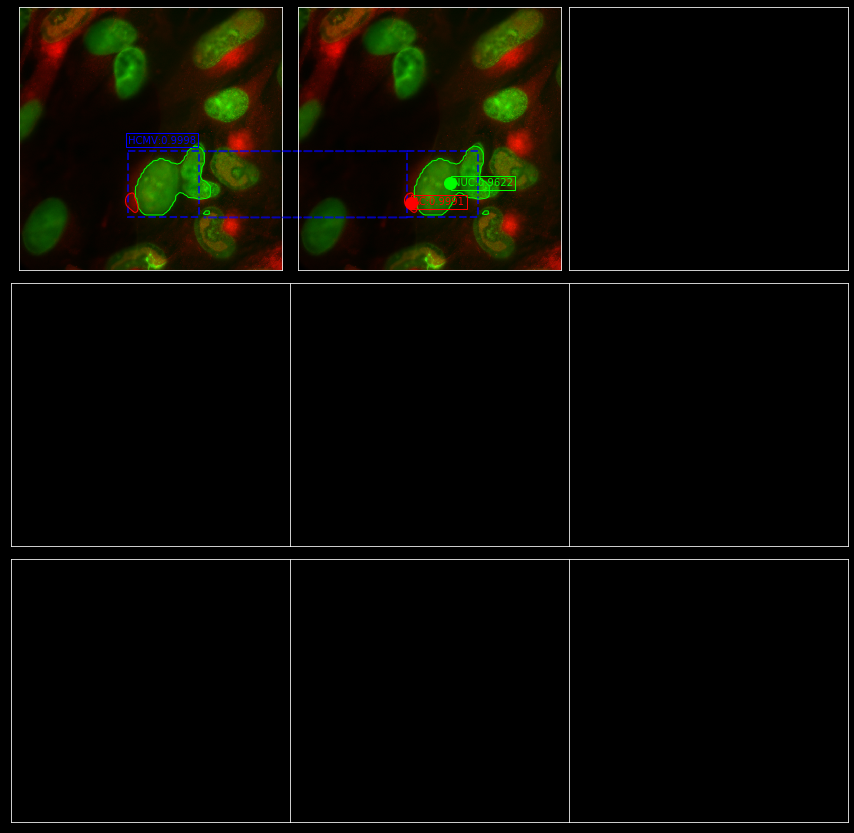

In [14]:
img_size = 1024

images_C1,images_C2,images_C3,images_C4 = prepare_image_channels(image_dir)

for image_no in range(1087,2501):
    img, image_C1, image_C2, image_C3, image_C4 = load_all_channels(image_no)
    #plt.imshow(img)
    #plt.show()
    masks, scores, rois, class_ids = get_results(img, visualize_instances=False) 
    mask_centroids = get_all_mask_centroids(class_ids,masks)
    for x in range(len(class_ids)):
        set_vars_none()
        TB_masking_rules = [class_ids[x] == 3,
                            scores[x] > 0.9995,
                            np.sum(masks[:,:,x]) > (125*125)]
        if all(TB_masking_rules):
            try:
                TB_mask, AC_mask, NUC_mask, TB_roi, AC_coords, NUC_coords, TB_score, AC_score, NUC_score = get_NUC_AC_masks(masks,rois,scores)
                edge_buffer = 25
                y1, x1, y2, x2 = TB_roi
                masking_rules = [0 <= y1-edge_buffer <= img_size,
                                 0 <= x1-edge_buffer <= img_size,
                                 0 <= y2+edge_buffer <= img_size,
                                 0 <= x2+edge_buffer <= img_size, 
                                 AC_score > 0.9,
                                 NUC_score > 0.9]
                if all(masking_rules):
                    display_mask_HCMV_rotateall(img,TB_mask,AC_mask,NUC_mask,TB_roi,AC_coords,NUC_coords,TB_score,AC_score,NUC_score, image_C1, image_C2, image_C3, image_C4)    
            except:
                #print(sys.exc_info())
                pass

In [13]:
image_folder = r"/tf/Mask_RCNN/data/TB96_CN99_4chanstack_FULLSIZE"
files = os.listdir(image_folder)
img_size = 1024

for file in files[0:20]:
    img = get_RGB_from_folder(image_folder,file)
    masks, scores, rois, class_ids = get_results(img, visualize_instances=False) 
    mask_centroids = get_all_mask_centroids(class_ids,masks)
    for x in range(len(class_ids)):
        set_vars_none()
        TB_masking_rules = [class_ids[x] == 3,
                            scores[x] > 0.9999,
                            np.sum(masks[:,:,x]) > (125*125)]
        if all(TB_masking_rules):
            try:
                TB_mask, AC_mask, NUC_mask, TB_roi, AC_coords, NUC_coords, TB_score, AC_score, NUC_score = get_NUC_AC_masks(masks,rois,scores)
                edge_buffer = 25
                y1, x1, y2, x2 = TB_roi
                masking_rules = [0 <= y1-edge_buffer <= img_size,
                                 0 <= x1-edge_buffer <= img_size,
                                 0 <= y2+edge_buffer <= img_size,
                                 0 <= x2+edge_buffer <= img_size, 
                                 AC_score > 0.9,
                                 NUC_score > 0.9]

                if all(masking_rules):
                    display_mask_HCMV(img,TB_mask,AC_mask,NUC_mask,TB_roi,AC_coords,NUC_coords,TB_score,AC_score,NUC_score)

            except:
                print(sys.exc_info())
                pass

KeyboardInterrupt: 

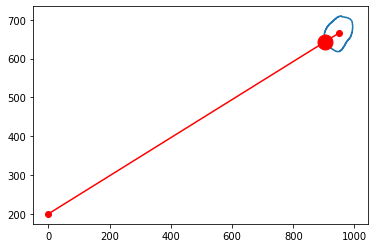

In [18]:
import matplotlib.pyplot as plt

x,y = polygon.exterior.xy
plt.plot(x,y)
line1_coords = line1.coords

plt.plot((line1_coords[0][0],line1_coords[1][0]),(line1_coords[0][1],line1_coords[1][1]), 'ro-')
plt.plot([int_pt.coords[1][0]],[int_pt.coords[1][1]],marker='o', markersize=15, color="red")
plt.show()

In [15]:
def rotate_align_AC(masked_image,int_x,int_y):
    SHIFT_x = int(masked_image.shape[0]/2 - int_x)
    SHIFT_y = int(masked_image.shape[1]/2 - int_y)
    image_rot = masked_image.rotate(AC_to_NUC_orientation_degrees,
                                        center=(int_x, int_y),
                                        translate=(SHIFT_x,SHIFT_y))
    return(image_rot)


def linescan_calculations(intersection_x,intersection_y,AC_to_NUC_orientation_radians, linescan_len):
    radius_len = 500/2
    X_AC_fixedradius = intersection_x + radius_len * np.cos(AC_to_NUC_orientation_radians - np.pi)
    Y_AC_fixedradius = intersection_y + radius_len * np.sin(AC_to_NUC_orientation_radians - np.pi)
    X_NUC_fixedradius = intersection_x + radius_len * np.cos(AC_to_NUC_orientation_radians)
    Y_NUC_fixedradius = intersection_y + radius_len * np.sin(AC_to_NUC_orientation_radians)
    return(X_AC_fixedradius,Y_AC_fixedradius,X_NUC_fixedradius,Y_NUC_fixedradius)


def detect_stack(r,image,image_id,image_stack): #,NUC_index,AC_index):
    
    AC_class_id = 1
    NUC_class_id = 2
    TB_class_id = 3

    masks = r['masks']
    #plot_all_masks(r,image)
    AC_mask_index = list(r['class_ids']).index(AC_class_id)
    NUC_mask_index = list(r['class_ids']).index(NUC_class_id)
    TB_mask_index = list(r['class_ids']).index(TB_class_id)
    
    NUC_mask = masks[:,:,NUC_mask_index]
    #NUC_mask = masks[:,:,NUC_index]
    AC_mask = masks[:,:,AC_mask_index]
    #AC_mask = masks[:,:,AC_index]
    #print(image.shape)
    
    NUC_cX, NUC_cY = get_mask_moments_centroid_only(NUC_mask)
    #print("NUC centroid:", NUC_cX,NUC_cY)
    AC_cX, AC_cY = get_mask_moments_centroid_only(AC_mask)
    #print("AC centroid:", AC_cX,AC_cY)
    

    #print("Midpoint:",MID_cX,MID_cY)

    color1 = (0.1, 0.2, 0.5)
    color2 = (0.2, 1.0, 0.0)
    alpha=0.25
    
    masked_image = overlay_masks(image,AC_mask,NUC_mask,color1,color2,alpha)
    masked_blank = overlay_masks(image*0,AC_mask,NUC_mask,color1,color2,0.5)
    #### TO DO make this 
    #### skimage.transform.rotate(image, angle, resize=False, center=None, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    
    image_rot = masked_image.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    
    masked_blank_rot = masked_blank.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y)) 

    #print("Rotate by:", AC_to_NUC_orientation_degrees)
                             
    image_stack_C1 = Image.fromarray(np.uint16(image_stack[:,:,0]))
    image_stack_C2 = Image.fromarray(np.uint16(image_stack[:,:,1]))
    image_stack_C3 = Image.fromarray(np.uint16(image_stack[:,:,2]))
    image_stack_C4 = Image.fromarray(np.uint16(image_stack[:,:,3]))
    
    image_stack_C1_rot = image_stack_C1.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    image_stack_C2_rot = image_stack_C2.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    image_stack_C3_rot = image_stack_C3.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    image_stack_C4_rot = image_stack_C4.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    os.makedirs('rotated',exist_ok=True)  
    skimage.io.imsave("rotated/{}_C1.tif".format(image_id),np.asanyarray(image_stack_C1_rot))
    skimage.io.imsave("rotated/{}_C2.tif".format(image_id),np.asanyarray(image_stack_C2_rot))
    skimage.io.imsave("rotated/{}_C3.tif".format(image_id),np.asanyarray(image_stack_C3_rot))
    skimage.io.imsave("rotated/{}_C4.tif".format(image_id),np.asanyarray(image_stack_C4_rot))
                             
    fig, ax = plt.subplots(2, 6,figsize=(20,7))

    ax[0,0].imshow(image, interpolation='nearest')
    ax[0,1].set_title("Mask")
    ax[0,1].imshow(masked_blank, interpolation='nearest')
    ax[0,1].plot([AC_cX, NUC_cX],[AC_cY, NUC_cY],'white')
    ax[0,1].scatter((AC_cX, NUC_cX,MID_cX), (AC_cY, NUC_cY, MID_cY))
    ax[0,2].imshow(image_stack_C1, interpolation='nearest')
    ax[0,3].imshow(image_stack_C2, interpolation='nearest')
    ax[0,4].imshow(image_stack_C3, interpolation='nearest')
    ax[0,5].imshow(image_stack_C4, interpolation='nearest')
    
    ax[1,0].imshow(image_rot, interpolation='nearest')
    ax[1,1].set_title("Mask")
    ax[1,1].imshow(masked_blank_rot, interpolation='nearest')
    #ax[1,1].plot([AC_cX, NUC_cX],[AC_cY, NUC_cY],'white')
    #ax[1,1].scatter((AC_cX, NUC_cX,MID_cX), (AC_cY, NUC_cY, MID_cY))
    ax[1,2].imshow(image_stack_C1_rot, interpolation='nearest')
    ax[1,3].imshow(image_stack_C2_rot, interpolation='nearest')
    ax[1,4].imshow(image_stack_C3_rot, interpolation='nearest')
    ax[1,5].imshow(image_stack_C4_rot, interpolation='nearest')
    
    plt.show()
    plt.close('all')

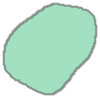

In [16]:
contours = find_contours(masks[:,:,0], 0.5)
polygon = []
for verts in contours:
    verts = np.fliplr(verts)
    polygon.append(verts)
polygon_array = np.array(polygon)
polygon = sPolygon(np.squeeze(polygon_array.astype(int)[0]))
polygon


In [17]:
line1 = LineString([centroid, (0,200)])
int_pt = line1.intersection(polygon)
int_pt.wkt
#point_of_intersection = int_pt.x, int_pt.y
#print(point_of_intersection)
#print(int_pt)
#ax2.plot(int_pt[0], int_pt[1], color=colors[2], marker='o', markersize=12)

'LINESTRING (948 665, 903 642.9272151898734)'

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  109.00000  uint8
image_meta               shape: (16,)                 min:    1.00000  max: 1024.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int64
gt_bbox                  shape: (3, 4)                min:  424.00000  max:  594.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


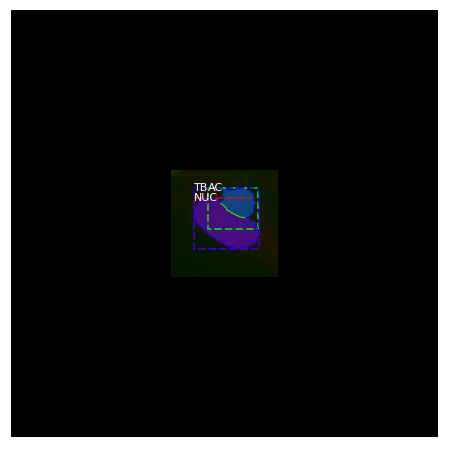

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  109.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  -14.70000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


26906.0

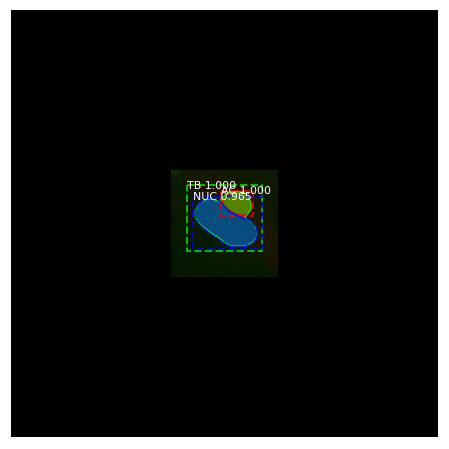

In [10]:
# Test on a random image
image_id = 2
#image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id) #, use_mini_mask=False)
#original_image = original_image[0]
#plt.imshow(original_image)
#plt.show()
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


#shows the total area of all arrays
np.reshape(r['masks'], (-1, r['masks'].shape[-1])).astype(np.float32).sum()


(948, 665)


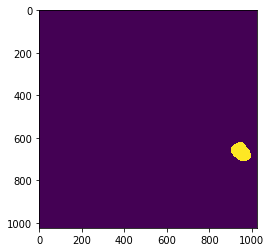

In [15]:
img = Image.open(os.path.join(image_folder, IMG_PATH))
img = img.resize((img_size,img_size))
img = np.array(img)
results = model.detect([img], verbose=0)
r=results[0]
masks = r['masks']
plt.imshow(masks[:,:,0])

centroid = get_mask_moments_centroid_only(masks[:,:,0])
print(centroid)

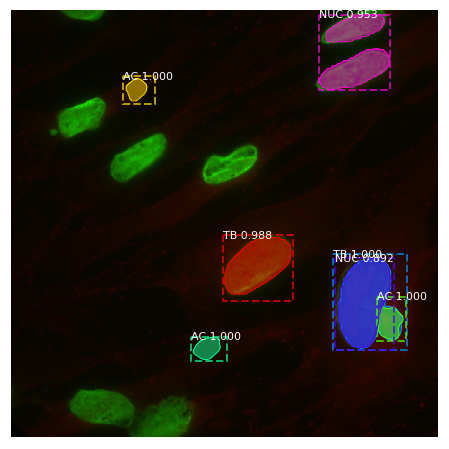

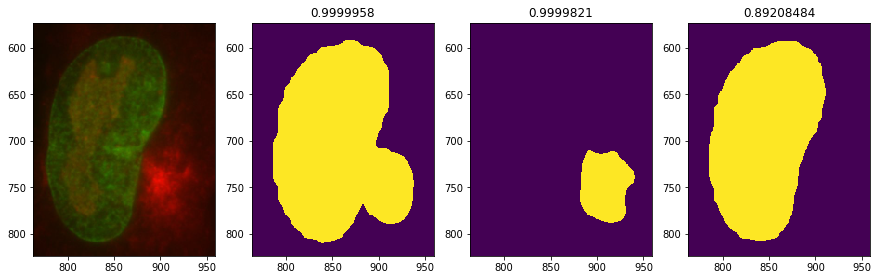

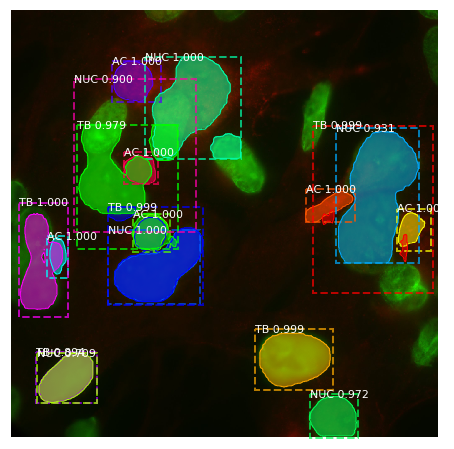

KeyboardInterrupt: 

In [12]:
image_folder = r"/tf/Mask_RCNN/data/TB96_CN99_4chanstack_FULLSIZE"
file_list = os.listdir(image_folder)

img_size = 1024

for IMG_PATH in file_list[0:100]:
    img = Image.open(os.path.join(image_folder, IMG_PATH))
    img = img.resize((img_size,img_size))
    img = np.array(img)

    results = model.detect([img], verbose=0)
    r=results[0]
    masks = r['masks']
    class_ids = r['class_ids']
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())
    plt.show()

    mask_centroids = get_all_mask_centroids(class_ids,masks)

    for x in range(len(r['class_ids'])):

        if r['class_ids'][x] == 3 and r["scores"][x] > 0.99999 and np.sum(r['masks'][:,:,x]) > (100*100): # and all(x in r['class_ids'] for x in [1,2,3]):
            try:
                TB_mask = r['masks'][:,:,x]
                NUC_min_dist_to_TB_index,AC_min_dist_to_TB_index = get_NUC_AC_closest_to_TB(mask_centroids,x)

                #retrieve the AC
                AC_mask = r['masks'][:,:,AC_min_dist_to_TB_index]
                AC_score = r["scores"][AC_min_dist_to_TB_index]

                #check if the NUC is TB, sometimes the segemntation fails, so dilate the AC
                if NUC_min_dist_to_TB_index == "TB" and r["scores"][x] > 0.99999:
                    AC_mask.astype(np.float32)
                    AC_mask_dilated = ndimage.binary_dilation(AC_mask,iterations=10).astype(AC_mask.dtype)
                    NUC_mask = TB_mask.astype(np.float32) - AC_mask_dilated
                    NUC_mask = NUC_mask == 1
                    NUC_score = 2
                    AC_mask.astype(bool)
                elif NUC_min_dist_to_TB_index == "TB" and r["scores"][x] < 0.99999:
                    print("EXCLUDE")
                    NUC_score = 0
                else:
                    NUC_mask = r['masks'][:,:,NUC_min_dist_to_TB_index]
                    NUC_score = r["scores"][NUC_min_dist_to_TB_index]

                dist_to_img_edge = 5


                masking_rules = [0 <= r['rois'][x][0]-dist_to_img_edge <= img_size,
                                 0 <= r['rois'][x][1]-dist_to_img_edge <= img_size,
                                 0 <= r['rois'][x][2]+dist_to_img_edge <= img_size,
                                 0 <= r['rois'][x][3]+dist_to_img_edge <= img_size,
                                 AC_score > 0.9,
                                 NUC_score > 0.8]
                                 #correct_nuc.sum()<TB_mask.sum()*0.3]


                if all(masking_rules):
                    fig, ax = plt.subplots(1,4,figsize=(15,5))
                    ax[0].imshow(img)
                    ax[1].imshow(TB_mask)
                    ax[1].set_title(r["scores"][x])
                    ax[2].imshow(AC_mask)
                    ax[2].set_title(AC_score)
                    ax[3].imshow(NUC_mask)
                    ax[3].set_title(NUC_score)

                    for i in [0,1,2,3]:
                        ax[i].set_xlim(r['rois'][x][1]-10,r['rois'][x][3]+10)
                        ax[i].set_ylim(r['rois'][x][2]+10,r['rois'][x][0]-10)
                    plt.show()
            except:
                pass
    #visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
    #                            dataset_val.class_names, r['scores'], ax=get_ax())
    #plt.show()
    

In [ ]:
import skimage.io
from skimage import exposure

image_dir = "/tf/Mask_RCNN/data/repG_fullsize_raw_first100/"
images = os.listdir(image_dir)

images_C1 = [k for k in images if '_w1_' in k]
images_C2 = [k for k in images if '_w2_' in k]
images_C3 = [k for k in images if '_w3_' in k]
images_C4 = [k for k in images if '_w4_' in k]


for image_no in range(1,100):
    image_no_string = "_s{}_".format(image_no)

    img_C1_path = [k for k in images_C1 if image_no_string in k]

    img_C4_path = [k for k in images_C4 if image_no_string in k]


    img_C1_16bit = skimage.io.imread(os.path.join(image_dir,img_C1_path[0]), as_gray=True, plugin='tifffile')
    img_C4_16bit = skimage.io.imread(os.path.join(image_dir,img_C4_path[0]), as_gray=True, plugin='tifffile')

    img_C1_16bit_adapteq = exposure.equalize_adapthist(img_C1_16bit, clip_limit=0.025)
    img_C4_16bit_adapteq = exposure.equalize_adapthist(img_C4_16bit, clip_limit=0.005)
    img_C1_8bit = (img_C1_16bit_adapteq*256).astype('uint8')
    img_C4_8bit = (img_C4_16bit_adapteq*256).astype('uint8')

    img_blank_8bit = img_C1_8bit * 0 # this makes it black
    #img_C3_8bit = img_C3_16bit/32).astype('uint8')\n",
    #img_C4_8bit = img_C3_16bit/32).astype('uint8')\n",

    merged_channels = cv2.merge((img_C1_8bit,img_C4_8bit,img_blank_8bit))
    #merged_channels_border = cv2.copyMakeBorder(merged_channels, img_border, img_border, img_border, img_border, cv2.BORDER_CONSTANT, value=0)
    #plt.imshow(merged_channels)

    img = Image.fromarray(merged_channels)
    img = img.resize((img_size,img_size))
    img = np.array(img)

    results = model.detect([img], verbose=0)
    r=results[0]
    masks = r['masks']
    class_ids = r['class_ids']
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())
    plt.show()
    
    mask_centroids = get_all_mask_centroids(class_ids,masks)

    for x in range(len(r['class_ids'])):
        #print("class id is:",r['class_ids'][x])
        
        TB_masking_rules = [r['class_ids'][x] == 3,
                            r["scores"][x] > 0.9999,
                            np.sum(r['masks'][:,:,x]) > (100*100)]

        if all(TB_masking_rules):
            try:
                TB_mask = r['masks'][:,:,x]
                NUC_min_dist_to_TB_index,AC_min_dist_to_TB_index = get_NUC_AC_closest_to_TB(mask_centroids,x)

                #retrieve the AC
                AC_mask = r['masks'][:,:,AC_min_dist_to_TB_index]
                AC_score = r["scores"][AC_min_dist_to_TB_index]

                #check if the NUC is TB, sometimes the segemntation fails, so dilate the AC
                if NUC_min_dist_to_TB_index == "TB" and r["scores"][x] > 0.99:
                #    AC_mask.astype(np.float32)
                #    AC_mask_dilated = ndimage.binary_dilation(AC_mask,iterations=10).astype(AC_mask.dtype)
                #    NUC_mask = TB_mask.astype(np.float32) - AC_mask_dilated
                #    NUC_mask = NUC_mask == 1
                #    NUC_score = 2
                #    AC_mask.astype(bool)
                #elif NUC_min_dist_to_TB_index == "TB" and r["scores"][x] < 0.99:
                    print("EXCLUDE")
                    NUC_score = 0
                else:
                    NUC_mask = r['masks'][:,:,NUC_min_dist_to_TB_index]
                    NUC_score = r["scores"][NUC_min_dist_to_TB_index]

                dist_to_img_edge = 0
                #correct_nuc = TB_mask.astype(np.float32) - NUC_mask.astype(np.float32) - AC_mask.astype(np.float32)
                #correct_nuc = correct_nuc == 1

                masking_rules = [0 <= r['rois'][x][0]-dist_to_img_edge <= img_size,
                                 0 <= r['rois'][x][1]-dist_to_img_edge <= img_size,
                                 0 <= r['rois'][x][2]+dist_to_img_edge <= img_size,
                                 0 <= r['rois'][x][3]+dist_to_img_edge <= img_size,
                                 AC_score > 0.999999,
                                 NUC_score > 0.9]
                                 #correct_nuc.sum()<TB_mask.sum()*0.3]


                if all(masking_rules):
                    fig, ax = plt.subplots(1,4,figsize=(15,5))
                    ax[0].imshow(img)
                    ax[1].imshow(TB_mask)
                    ax[1].set_title(r["scores"][x])
                    ax[2].imshow(AC_mask)
                    ax[2].set_title(AC_score)
                    ax[3].imshow(NUC_mask)
                    ax[3].set_title(NUC_score)

                    for i in [0,1,2,3]:
                        ax[i].set_xlim(r['rois'][x][1]-10,r['rois'][x][3]+10)
                        ax[i].set_ylim(r['rois'][x][2]+10,r['rois'][x][0]-10)
                    plt.show()
            except:
                pass
    

In [ ]:


color = (0.02, 0.0, 1.0)
def overlay_single_mask(image,mask,color,alpha):
    masked_image = image.astype(np.uint32).copy()
    for c in range(3):
        masked_image[:, :, c] = np.where(mask == 1,
                                  masked_image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  masked_image[:, :, c])
    masked_image = Image.fromarray(np.uint8(masked_image))
    return(masked_image)

def get_NUC_AC_closest_to_TB(all_mask_centroids,TB_mask_index):
    AC_class_id = 1
    NUC_class_id = 2
    mask_centroid_distance = []
    #get distances between TB and all other centroids
    for id in range(len(all_mask_centroids)):
        distance = np.hypot(
            (all_mask_centroids[id][0] - all_mask_centroids[TB_mask_index][0]),
            (all_mask_centroids[id][1] - all_mask_centroids[TB_mask_index][1]))
        mask_centroid_distance.append(distance)
    #make distances of TB NaN
    mask_centroid_distance[TB_mask_index] = np.NaN
    #make distances of nuclei NaN
    for id in range(len(all_mask_centroids)):
        if r['class_ids'][id] == NUC_class_id:
            mask_centroid_distance[id] = np.NaN
            AC_min_dist_to_TB_index = np.nanargmin(mask_centroid_distance) 
        if r['class_ids'][id] == AC_class_id:
            mask_centroid_distance[id] = np.NaN
            NUC_min_dist_to_TB_index = np.nanargmin(mask_centroid_distance) 
            
    #get the index of the AC closest to NUC
    
    #get the index of the AC closest to NUC
    
    return(NUC_min_dist_to_TB_index,AC_min_dist_to_TB_index)

In [ ]:
import os
import numpy as np
import cv2
from skimage import transform
from PIL import Image

FULL_SIZE_FOLDER = "/tf/Mask_RCNN/data/TB96_CN99_4chanstack_FULLSIZE/"
FULL_SIZE_IMAGE = os.listdir(FULL_SIZE_FOLDER)

#### THIS ONE WILL DISPALY JUST THE SINGLE MASKs and proximal AC and NUC
for image_no in range(len(FULL_SIZE_IMAGE)):
    img_original = Image.open(os.path.join(FULL_SIZE_FOLDER,FULL_SIZE_IMAGE[image_no]))
    img = img_original.resize((448,448))
    img = np.array(img)
    results = model.detect([img], verbose=0)
    r = results[0]
    masks = r['masks']
    class_ids = r['class_ids']
    mask_centroids = get_all_mask_centroids(class_ids,masks)

    for x in range(len(r['class_ids'])):
        #print("class id is:",r['class_ids'][x])

        if r['class_ids'][x] == 3 and r["scores"][x] > 0.975 and all(x in r['class_ids'] for x in [1,2,3]):
            #print("THIS IS THE AC")
            TB_mask = r['masks'][:,:,x]
            NUC_min_dist_to_TB_index,AC_min_dist_to_TB_index = get_NUC_AC_closest_to_TB(mask_centroids,x)
            AC_mask = r['masks'][:,:,AC_min_dist_to_TB_index]
            NUC_mask = r['masks'][:,:,NUC_min_dist_to_TB_index]
            
            fig, ax = plt.subplots(1,4,figsize=(15,5))
            ax[0].imshow(img)
            ax[1].imshow(TB_mask)
            ax[1].set_title(r["scores"][x])
            ax[2].imshow(AC_mask)
            ax[3].imshow(NUC_mask)
            
            for i in [0,1,2,3]:
                ax[i].set_xlim(r['rois'][x][1]-10,r['rois'][x][3]+10)
                ax[i].set_ylim(r['rois'][x][0]-10,r['rois'][x][2]+10)
            plt.show()


In [ ]:
import os
import numpy as np
import cv2
from skimage import transform
from skimage import util
from PIL import Image

FULL_SIZE_FOLDER = "/tf/Mask_RCNN/data/TB96_CN99_4chanstack_FULLSIZE/"
FULL_SIZE_IMAGE = os.listdir(FULL_SIZE_FOLDER)

#### THIS ONE WILL DISPALY JUST THE SINGLE 
for image_no in range(len(FULL_SIZE_IMAGE)):
    img_original = Image.open(os.path.join(FULL_SIZE_FOLDER,FULL_SIZE_IMAGE[image_no]))
    img = img_original.resize((448,448))
    img = np.array(img)
    results = model.detect([img], verbose=0)
    r = results[0]
    masks = r['masks']
    class_ids = r['class_ids']
    mask_centroids = get_all_mask_centroids(class_ids,masks)

    for x in range(len(r['class_ids'])):
        #print("class id is:",r['class_ids'][x])

        if r['class_ids'][x] == 3 and r["scores"][x] > 0.95 and all(x in r['class_ids'] for x in [1,2,3]):
            try:
                #print("THIS IS THE AC")
                TB_mask = r['masks'][:,:,x]
                TB_x1 = r['rois'][x][1] -10
                TB_x2 = r['rois'][x][3] +10
                TB_y1 = r['rois'][x][0] -10
                TB_y2 = r['rois'][x][2] +10
                TB_img_cropped = img[TB_y1:TB_y2,TB_x1:TB_x2]
                #NUC_min_dist_to_TB_index,AC_min_dist_to_TB_index = get_NUC_AC_closest_to_TB(mask_centroids,x)
                #AC_mask = r['masks'][:,:,AC_min_dist_to_TB_index]
                #NUC_mask = r['masks'][:,:,NUC_min_dist_to_TB_index]

                results2 = model.detect([TB_img_cropped], verbose=0)
                r2 = results2[0]
                masks2 = r2['masks']
                #plot_all_masks(r2,TB_img_cropped)
                AC_class_id = 1
                NUC_class_id = 2
                #plot_all_masks(r,image)
                class_ids2 = r2['class_ids']
                #print(class_ids2)
                AC_mask_index = list(class_ids2).index(AC_class_id)
                NUC_mask_index = list(class_ids2).index(NUC_class_id)
                #print(AC_mask_index)
                #print(NUC_mask_index)
                masked_img_TB = overlay_single_mask(img,TB_mask,color,0.25)
                fig, ax = plt.subplots(1,3,figsize=(15,5))
                ax[0].imshow(masked_img_TB)
                #ax[1].imshow(TB_img_cropped)
                #ax[1].imshow(TB_mask)
                #ax[1].set_title(r["scores"][x])
                ax[1].imshow(masks2[:,:,AC_mask_index])
                ax[2].imshow(masks2[:,:,NUC_mask_index])

                for i in [0]:
                    ax[i].set_xlim(TB_x1,TB_x2)
                    ax[i].set_ylim(TB_y2,TB_y1)
                plt.show()
            except:
                pass


In [ ]:
"""
if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        #TB_maks = 
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        plt.imshow(mask[:,:,0], extent = [0, 1216, 0, 1216],interpolation='nearest')
        plt.show()


if (mask_n > 0):
    
    fig, ax = plt.subplots(3, 3,figsize=(21,21))
    ax[0,0].imshow(r["masks"][:,:,0], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[0,1].imshow(r["masks"][:,:,1], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[0,2].imshow(r["masks"][:,:,2], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[1,0].imshow(r["masks"][:,:,3], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[1,1].imshow(r["masks"][:,:,4], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[1,2].imshow(r["masks"][:,:,5], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[2,0].imshow(r["masks"][:,:,6], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[2,1].imshow(r["masks"][:,:,7], extent = [0, 1216, 0, 1216],interpolation='nearest')
    ax[2,2].imshow(r["masks"][:,:,8], extent = [0, 1216, 0, 1216],interpolation='nearest')
    plt.show()
    plt.close('all')
#plot_all_masks(r,img)
plt.imshow(img)


#img_cropped = img[750-100:1350-100,750+150:1350+150]
#plt.imshow(img_cropped)
#plt.show()
#results = model.detect([img_cropped], verbose=0)
#r = results[0]
#plot_all_masks(r,img_cropped)
#visualize.display_instances(cropped_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())
crop_dims = 150
step_size = 250
image_dims = 2048
for y in range(step_number): 
    for x in range(step_number):
        cropped_image = img[int((y*step_size)):int(((y+1)*step_size)+crop_dims),
                            int((x*step_size)):int(((x+1)*step_size)+crop_dims)]
        #print(cropped_image.shape)
        #plt.imshow(cropped_image)
        #plt.show()
        results = model.detect([cropped_image], verbose=0)
        r = results[0]
        try:
            #plot_all_masks(r,cropped_image)
            mask_n = len(r["class_ids"])
            if (mask_n > 0):
                fig, ax = plt.subplots(1, mask_n+1,figsize=(21,7))
                ax[0].imshow(cropped_image)
                for i in range(mask_n):
                    ax[i+1].set_title(r["scores"][i])
                    ax[i+1].imshow(r["masks"][:,:,i], extent = [0, 1216, 0, 1216],interpolation='nearest')
                #plt.savefig("results0149masks/121_20200105_{}_EPOCH_0130.jpg".format(image_id),bbox_inches = 'tight', pad_inches = 0)
                plt.show()
                plt.close('all')
        except:
            pass


img = transform.resize(img, (int(2048/6),int(2048/6)))
plt.imshow(img)
plt.show()

crop_dims = 300/6
step_size = 250/6
image_dims = 2048/6

step_number = int((image_dims - crop_dims)/step_size)
print(step_number)
for y in range(step_number): 
    for x in range(step_number):
        cropped_image = img[int((y*step_size)):int(((y+1)*step_size)+crop_dims),
                            int((x*step_size)):int(((x+1)*step_size)+crop_dims)]
        plt.imshow(cropped_image)
        plt.show()
        results = model.detect([cropped_image], verbose=0)
        print(results)
        #visualize.display_instances(cropped_image, r['rois'], r['masks'], r['class_ids'],
        #                            dataset_val.class_names, r['scores'], ax=get_ax())
        plt.show()

#y_len,x_len,_=img.shape
#mean_values=[]

        plt.imshow(cropped_image)
        plt.show()
        #results = model.detect([cropped_image], verbose=0)
        #r = results[0]
        #visualize.display_instances(cropped_image, r['rois'], r['masks'], r['class_ids'],
        #                            dataset_val.class_names, r['scores'], ax=get_ax())
        plt.show()


#results = model.detect([img], verbose=0)
#r=results[0]
#r['masks']
#print(r["masks"])
#print(r)

plt.imshow(img)
plt.show()
plt.imshow(r['masks'][:,:,0],extent = [0, 2048, 0, 2048])
plt.show()
plt.imshow(r['masks'][:,:,1],extent = [0, 2048, 0, 2048])
plt.show()
plt.imshow(r['masks'][:,:,2],extent = [0, 2048, 0, 2048])
plt.show()
#visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())
"""

In [ ]:
import HCMVcc_MaskRCNN as HCMVmrcnn

test_images_folder = "/tf/Mask_RCNN/data/TB96_CNN99_RG_JPG_test/"
test_images_paired_channels_folder =  "/tf/Mask_RCNN/data/TB96_CN99_4chanstack/"
HCMVmrcnn.load_images_from_folder(test_images_folder,test_images_paired_channels_folder)

In [ ]:
def plot_all_masks(r,image):
    mask_n = len(r["class_ids"])
    fig, ax = plt.subplots(1, mask_n+1,figsize=(21,7))
    ax[0].imshow(image)
    for i in range(mask_n):
        ax[i+1].set_title(r["scores"][i])
        ax[i+1].imshow(r["masks"][:,:,i], extent = [0, 1216, 0, 1216],interpolation='nearest')
    #plt.savefig("results0149masks/121_20200105_{}_EPOCH_0130.jpg".format(image_id),bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    plt.close('all')

def get_mask_moments_centroid_only(mask):
    # calculate moments of binary image
    mask_M = cv2.moments(mask.astype(np.uint8))
    mask_cX = int(mask_M["m10"] / mask_M["m00"])
    mask_cY = int(mask_M["m01"] / mask_M["m00"])
    return(mask_cX, mask_cY)

color1 = (0.020000000000000462, 0.0, 1.0)
color2 = (0.20000000000000018, 1.0, 0.0)
alpha=0.25

def overlay_masks(image,mask1,mask2,color1,color2,alpha):
    masked_image = image.astype(np.uint32).copy()
    for c in range(3):
        masked_image[:, :, c] = np.where(mask1 == 1,
                                  masked_image[:, :, c] *
                                  (1 - alpha) + alpha * color1[c] * 255,
                                  masked_image[:, :, c])
        masked_image[:, :, c] = np.where(mask2 == 1,
                                  masked_image[:, :, c] *
                                  (1 - alpha) + alpha * color2[c] * 255,
                                  masked_image[:, :, c])
    masked_image = Image.fromarray(np.uint8(masked_image))
    return(masked_image)



In [ ]:
import os
import skimage.io
import skimage.external.tifffile

test_images_folder = "/tf/Mask_RCNN/data/TB96_CNN99_RG_JPG_test/"
test_images_paired_channels_folder =  "/tf/Mask_RCNN/data/TB96_CN99_4chanstack/"



dir_list = os.listdir(test_images_folder)
paired_list = os.listdir(test_images_paired_channels_folder)

#os.makedirs("results_averageproj",exist_ok=True)
#print(os.listdir(folder))

def load_images_from_folder(folder1,folder2):

    for filename in dir_list:
        try:
            #fig, ax = plt.subplots(figsize=(21,7))
            img = skimage.io.imread(os.path.join(folder1,filename))
            img_stack = skimage.io.imread(os.path.join(folder2,filename[:-8]+".tif"))
            results = model.detect([img], verbose=0)
            r = results[0]
            detect_stack(r,img,filename,img_stack)
            #d.append({'Unique_ID':filename,
            #  'rois':r['rois'], 
            #  'masks':r['masks'], 
            #  'class_ids':r['class_ids'], 
            #  'scores':r['scores']})
            #visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
            #                            dataset_val.class_names, r['scores'], ax=get_ax())
            #fig, ax = plt.subplots(1, 1,figsize=(15,15))
            #img = cv2.imread(os.path.join(folder,filename))
            #ax.imshow(img)
            #plt.savefig("results_averageproj/{}_MASKRCNN_RESULT_128x128.png".format(filename))
            plt.show()
            plt.close()
        except:
            pass

In [ ]:
load_images_from_folder(test_images_folder,test_images_paired_channels_folder)

In [ ]:
### Check to see if these have all been exported
import os
print(len(os.listdir(test_images_folder)))
print(len(os.listdir("results_averageproj")))
if (len(os.listdir(test_images_folder)) == len(os.listdir("results_averageproj"))):
       print("ALL IMAGES HAVE BEEN EXPORTED")


#### NOW EXPORT THE OTHER CHANNELS INTO STACKS AND SAVE THEM SEPARATELY



### SEE IF WE CAN PERFORM LINESCNAS USING THIS METHOD AND HOW THAT COMPARES
df_results.head()


In [ ]:
mask1 = AC_mask
mask2 = NUC_mask

In [ ]:
def detect_stack(r,image,image_id,image_stack): #,NUC_index,AC_index):
    
    AC_class_id = 1
    NUC_class_id = 2
    TB_class_id = 3

    masks = r['masks']
    #plot_all_masks(r,image)
    AC_mask_index = list(r['class_ids']).index(AC_class_id)
    NUC_mask_index = list(r['class_ids']).index(NUC_class_id)
    TB_mask_index = list(r['class_ids']).index(TB_class_id)
    
    NUC_mask = masks[:,:,NUC_mask_index]
    #NUC_mask = masks[:,:,NUC_index]
    AC_mask = masks[:,:,AC_mask_index]
    #AC_mask = masks[:,:,AC_index]
    #print(image.shape)
    
    NUC_cX, NUC_cY = get_mask_moments_centroid_only(NUC_mask)
    #print("NUC centroid:", NUC_cX,NUC_cY)
    AC_cX, AC_cY = get_mask_moments_centroid_only(AC_mask)
    #print("AC centroid:", AC_cX,AC_cY)
    
    AC_to_NUC_orientation_radians =  np.arctan2((AC_cY - NUC_cY),(AC_cX - NUC_cY))
    
    if AC_to_NUC_orientation_radians <0:
        AC_to_NUC_orientation_radians = 2*np.pi+AC_to_NUC_orientation_radians
    
    AC_to_NUC_orientation_degrees = np.degrees(AC_to_NUC_orientation_radians)
    
    MID_cX = int((NUC_cX + AC_cX)/2)
    MID_cY = int((NUC_cY + AC_cY)/2)
    SHIFT_x = int(image.shape[0]/2 - MID_cX)
    SHIFT_y = int(image.shape[1]/2 - MID_cY)
    #print("Midpoint:",MID_cX,MID_cY)

    color1 = (0.1, 0.2, 0.5)
    color2 = (0.2, 1.0, 0.0)
    alpha=0.25
    
    masked_image = overlay_masks(image,AC_mask,NUC_mask,color1,color2,alpha)
    masked_blank = overlay_masks(image*0,AC_mask,NUC_mask,color1,color2,0.5)
    #### TO DO make this 
    #### skimage.transform.rotate(image, angle, resize=False, center=None, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    
    image_rot = masked_image.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    
    masked_blank_rot = masked_blank.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y)) 

    #print("Rotate by:", AC_to_NUC_orientation_degrees)
                             
    image_stack_C1 = Image.fromarray(np.uint16(image_stack[:,:,0]))
    image_stack_C2 = Image.fromarray(np.uint16(image_stack[:,:,1]))
    image_stack_C3 = Image.fromarray(np.uint16(image_stack[:,:,2]))
    image_stack_C4 = Image.fromarray(np.uint16(image_stack[:,:,3]))
    
    image_stack_C1_rot = image_stack_C1.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    image_stack_C2_rot = image_stack_C2.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    image_stack_C3_rot = image_stack_C3.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    image_stack_C4_rot = image_stack_C4.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y))
    os.makedirs('rotated',exist_ok=True)  
    skimage.io.imsave("rotated/{}_C1.tif".format(image_id),np.asanyarray(image_stack_C1_rot))
    skimage.io.imsave("rotated/{}_C2.tif".format(image_id),np.asanyarray(image_stack_C2_rot))
    skimage.io.imsave("rotated/{}_C3.tif".format(image_id),np.asanyarray(image_stack_C3_rot))
    skimage.io.imsave("rotated/{}_C4.tif".format(image_id),np.asanyarray(image_stack_C4_rot))
                             
    fig, ax = plt.subplots(2, 6,figsize=(20,7))

    ax[0,0].imshow(image, interpolation='nearest')
    ax[0,1].set_title("Mask")
    ax[0,1].imshow(masked_blank, interpolation='nearest')
    ax[0,1].plot([AC_cX, NUC_cX],[AC_cY, NUC_cY],'white')
    ax[0,1].scatter((AC_cX, NUC_cX,MID_cX), (AC_cY, NUC_cY, MID_cY))
    ax[0,2].imshow(image_stack_C1, interpolation='nearest')
    ax[0,3].imshow(image_stack_C2, interpolation='nearest')
    ax[0,4].imshow(image_stack_C3, interpolation='nearest')
    ax[0,5].imshow(image_stack_C4, interpolation='nearest')
    
    ax[1,0].imshow(image_rot, interpolation='nearest')
    ax[1,1].set_title("Mask")
    ax[1,1].imshow(masked_blank_rot, interpolation='nearest')
    #ax[1,1].plot([AC_cX, NUC_cX],[AC_cY, NUC_cY],'white')
    #ax[1,1].scatter((AC_cX, NUC_cX,MID_cX), (AC_cY, NUC_cY, MID_cY))
    ax[1,2].imshow(image_stack_C1_rot, interpolation='nearest')
    ax[1,3].imshow(image_stack_C2_rot, interpolation='nearest')
    ax[1,4].imshow(image_stack_C3_rot, interpolation='nearest')
    ax[1,5].imshow(image_stack_C4_rot, interpolation='nearest')
    
    plt.show()
    plt.close('all')

In [ ]:
import cv2
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import colorsys
from PIL import Image

def detect(r,image,image_id): #,NUC_index,AC_index):
    
    AC_class_id = 1
    NUC_class_id = 2
    TB_class_id = 3

    masks = r['masks']
    #plot_all_masks(r,image)
    AC_mask_index = list(r['class_ids']).index(AC_class_id)
    NUC_mask_index = list(r['class_ids']).index(NUC_class_id)
    TB_mask_index = list(r['class_ids']).index(TB_class_id)
    
    NUC_mask = masks[:,:,NUC_mask_index]
    #NUC_mask = masks[:,:,NUC_index]
    AC_mask = masks[:,:,AC_mask_index]
    #AC_mask = masks[:,:,AC_index]
    print(image.shape)
    
    NUC_cX, NUC_cY = get_mask_moments_centroid_only(NUC_mask)
    print("NUC centroid:", NUC_cX,NUC_cY)
    AC_cX, AC_cY = get_mask_moments_centroid_only(AC_mask)
    print("AC centroid:", AC_cX,AC_cY)
    
    AC_to_NUC_orientation_radians =  np.arctan2((AC_cY - NUC_cY),(AC_cX - NUC_cY))
    
    if AC_to_NUC_orientation_radians <0:
        AC_to_NUC_orientation_radians = 2*np.pi+AC_to_NUC_orientation_radians
    
    AC_to_NUC_orientation_degrees = np.degrees(AC_to_NUC_orientation_radians)
    
    MID_cX = int((NUC_cX + AC_cX)/2)
    MID_cY = int((NUC_cY + AC_cY)/2)
    SHIFT_x = int(image.shape[0]/2 - MID_cX)
    SHIFT_y = int(image.shape[1]/2 - MID_cY)
    print("Midpoint:",MID_cX,MID_cY)

    #rotated_image = ndimage.rotate(masked_image, orientation_degrees-180,reshape=False)

    #N=100
    #colors = None
    #colors = colors or random_colors(N)
    #i=99
    #color = colors[i]
    #print("color is", color)
    #color2 = colors[i-1]
    #print("color2 is", color2)

    color1 = (0.1, 0.2, 0.5)
    color2 = (0.2, 1.0, 0.0)
    alpha=0.25
    masked_image = overlay_masks(image,AC_mask,NUC_mask,color1,color2,alpha)
    masked_blank = overlay_masks(image*0,AC_mask,NUC_mask,color1,color2,0.5)
    rotated_image = masked_image.rotate(AC_to_NUC_orientation_degrees,
                                            center=(MID_cX, MID_cY),
                                            translate=(SHIFT_x,SHIFT_y)) 

    print("Rotate by:", AC_to_NUC_orientation_degrees)
    
    
    fig, ax = plt.subplots(1, 4,figsize=(15,15))

    ax[0].set_title("AC_Mask")
    ax[0].imshow(masked_blank, interpolation='nearest')
    ax[0].scatter(AC_cX, AC_cY)

    ax[1].set_title("NUC_Mask")
    ax[1].imshow(NUC_mask, interpolation='nearest')
    ax[1].scatter(NUC_cX, NUC_cY)

    ax[2].imshow(masked_image, interpolation='nearest')
    
    ax[2].plot([AC_cX, NUC_cX],[AC_cY, NUC_cY],'white')
    ax[2].scatter((AC_cX, NUC_cX,MID_cX), (AC_cY, NUC_cY, MID_cY))

    ax[3].set_title("Rotated")
    ax[3].imshow(rotated_image, interpolation='nearest')
    ax[3].scatter(image.shape[0]/2,image.shape[1]/2)
    
    #plt.savefig("results0149full/121_20200105_{}_EPOCH_0130.jpg".format(image_id),bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    plt.close('all')
"""
for image_id in range(1,len(dataset.image_ids)-1):
        try:
            #image_id = random.choice(dataset.image_ids)
            r, image = get_predictions_from_ID(image_id)
            #plot_all_masks(r,image)
            #print("Class IDs:", r['class_ids'])
            NUC_max_area_index,AC_min_dist_to_NUC_index = get_NUC_AC_indicies(r,NUC_class_id=2,AC_class_id=1)
            detect(r,image,image_id,NUC_max_area_index,AC_min_dist_to_NUC_index)
        except:
            pass
"""

In [ ]:
results = model.detect([img], verbose=1)

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))